In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch.nn as nn
import torch
import types

In [22]:
# Now define a model

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv_section1 = nn.Sequential(
            nn.Conv1d(1, 128, 10),
            nn.ReLU(),
            nn.MaxPool1d(2, ceil_mode=True),
            nn.BatchNorm1d(128)
        )

        self.conv_section2 = nn.Sequential(
            nn.Conv1d(128, 64, 7),
            nn.ReLU(),
            nn.MaxPool1d(2, ceil_mode=True),
            nn.BatchNorm1d(64)
        )

        self.conv_section3 = nn.Sequential(
            nn.Conv1d(64, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(2, ceil_mode=True),
            nn.BatchNorm1d(32)
        )

        self.conv_section4 = nn.Sequential(
            nn.Conv1d(32, 16, 3),
            nn.ReLU(),
            nn.MaxPool1d(2, ceil_mode=True),
            nn.BatchNorm1d(16)
        )

        self.conv_section5 = nn.Sequential(
            nn.Conv1d(16, 8, 3),
            nn.ReLU(),
            nn.MaxPool1d(2, ceil_mode=True),
            nn.BatchNorm1d(8)
        )

        self.conv_section6 = nn.Sequential(
            nn.Conv1d(8, 8, 3),
            nn.ReLU(),
            nn.MaxPool1d(2, ceil_mode=True),
            nn.BatchNorm1d(8)
        )

        self.dense1 = nn.Linear(1112, 256)
        self.dense2 = nn.Linear(256, 64)
        self.dense3 = nn.Linear(64, 4)

        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2)
        self.maxpool_ceil = nn.MaxPool1d(2, ceil_mode=True)
        self.logsoftmax = nn.LogSoftmax(dim=-1)

        self.dropout = nn.Dropout()

    def forward(self, x):

        # [1, 9000]
        x = self.conv_section1(x)

        # [512, 4499]
        x = self.conv_section2(x)

        # [256, 2249]
        x = self.conv_section3(x)

        # [128, 1124]
        x = self.conv_section4(x)

        # [64, 561]
        x = self.conv_section5(x)

        # [32, 280]
        x = self.conv_section6(x)

        # [32, 139]
        x = torch.flatten(x, start_dim=-2)

        # [4448]
        x = self.dense1(x)
        x = self.activation(x)
        x = self.dropout(x)

        # [1024]
        x = self.dense2(x)
        x = self.activation(x)
        x = self.dropout(x)

        # [128]
        x = self.dense3(x)
        x = self.logsoftmax(x)
        # [4]
        return x

In [23]:
model = CNN()
model.load_state_dict(torch.load("TrainedModels/CNN.pt"))
model.eval()

CNN(
  (conv_section1): Sequential(
    (0): Conv1d(1, 128, kernel_size=(10,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_section2): Sequential(
    (0): Conv1d(128, 64, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_section3): Sequential(
    (0): Conv1d(64, 32, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_section4): Sequential(
    (0): Conv1d(32, 16, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, d

In [24]:
def get_all_layers(model_children, layer_type):
  for layer in model_children:
    for t in layer_type:
        if type(layer) == t:
            yield layer
    if type(layer) == nn.Sequential:
        yield get_all_layers(layer, layer_type)

def fill_list_from_generators(gen, list):
    for item in gen:
        if isinstance(item, types.GeneratorType):
            fill_list_from_generators(item, list)
        else:
            list.append(item)

In [25]:
# get all the model children as list
model_children = list(model.children())
conv_layers = []
fill_list_from_generators(get_all_layers(model_children, (nn.Conv1d,)), conv_layers)
model_weights = [layer.weight for layer in conv_layers]

In [26]:
# take a look at the conv layers and the respective weights
for i, (weight, conv) in enumerate(zip(model_weights, conv_layers)):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"{i} CONV: {conv} ====> SHAPE: {weight.shape}")

0 CONV: Conv1d(1, 128, kernel_size=(10,), stride=(1,)) ====> SHAPE: torch.Size([128, 1, 10])
1 CONV: Conv1d(128, 64, kernel_size=(7,), stride=(1,)) ====> SHAPE: torch.Size([64, 128, 7])
2 CONV: Conv1d(64, 32, kernel_size=(5,), stride=(1,)) ====> SHAPE: torch.Size([32, 64, 5])
3 CONV: Conv1d(32, 16, kernel_size=(3,), stride=(1,)) ====> SHAPE: torch.Size([16, 32, 3])
4 CONV: Conv1d(16, 8, kernel_size=(3,), stride=(1,)) ====> SHAPE: torch.Size([8, 16, 3])
5 CONV: Conv1d(8, 8, kernel_size=(3,), stride=(1,)) ====> SHAPE: torch.Size([8, 8, 3])


## Convolutional Filter Visualisation

We can plot the convolution filters of the trained network. The shapes should resemble the snhapes which the filter detects in the input (and passes to the next layer).

LAYER_NUM selects the layer of the network to view.

IN_CHANNEL_NUM selects the input channel for which to view the filters for

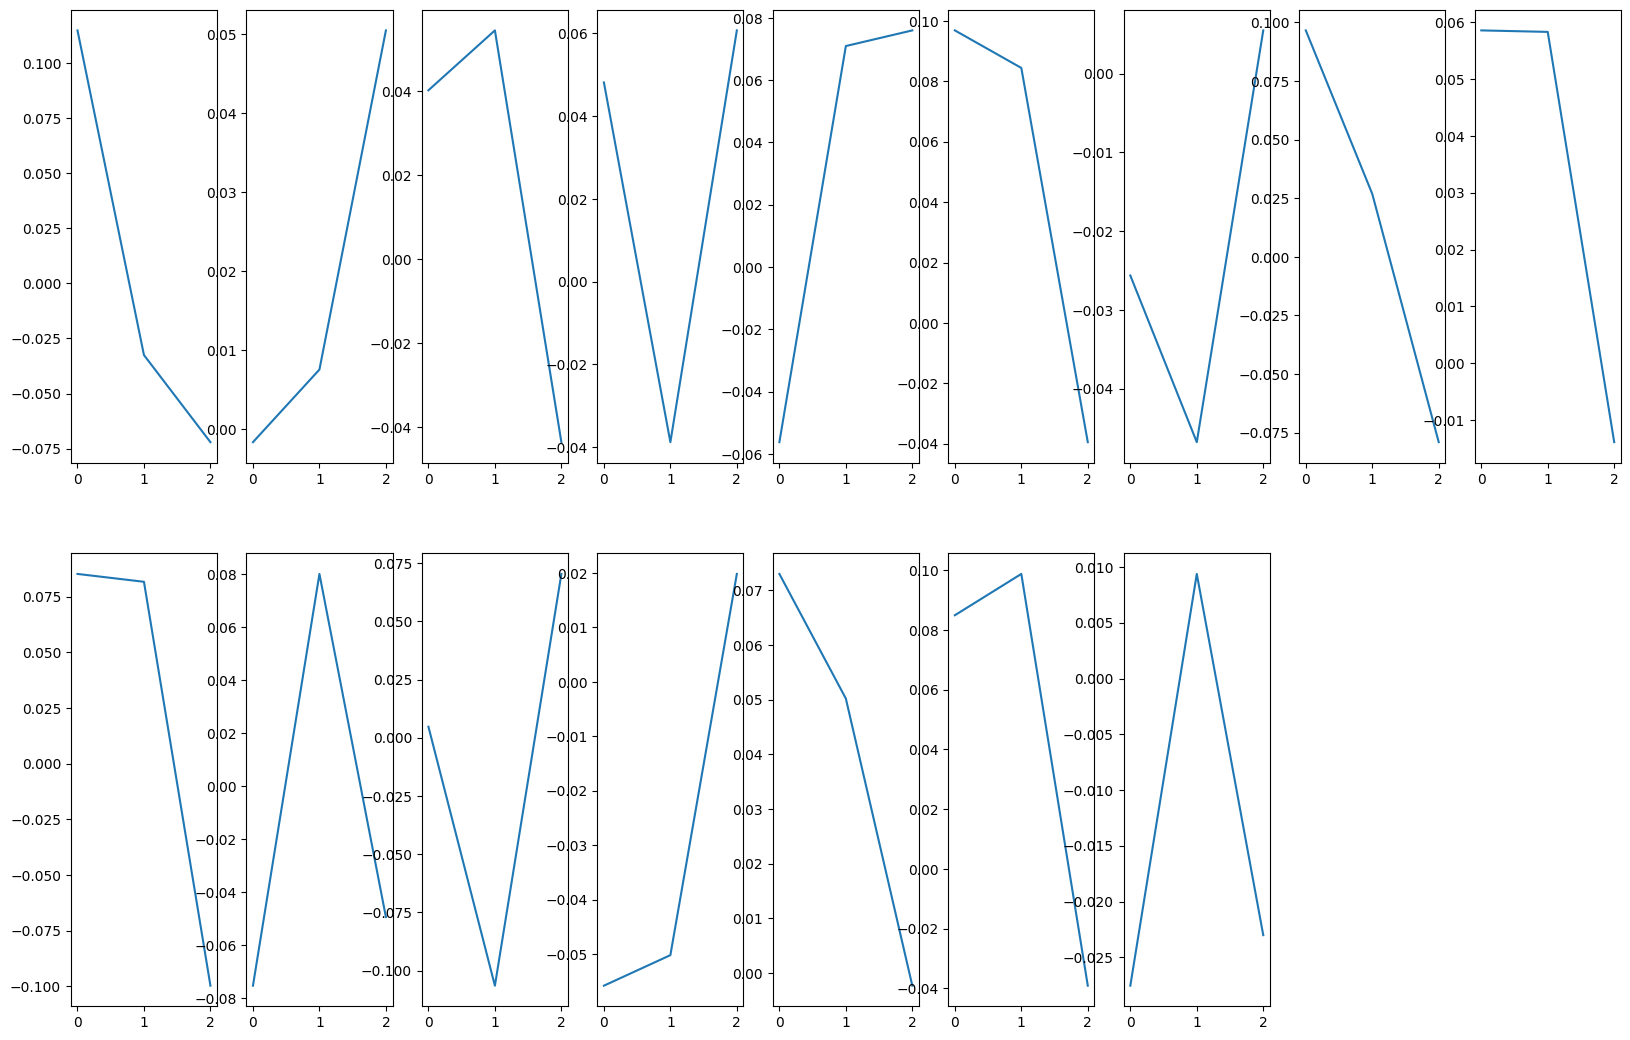

In [34]:
# visualize conv layer filters
LAYER_NUM = 3
IN_CHANNEL_NUM = 0
num_filters = model_weights[LAYER_NUM].shape[0]

plt.figure(figsize=(20, 20))
for i, filter in enumerate(model_weights[LAYER_NUM]):
    plt.subplot(num_filters//8 + 1, 8 + 1, i+1)
    plt.plot(filter[IN_CHANNEL_NUM, :].detach().cpu())
    # plt.axis('off')

plt.show()

### Visualise intermediate signals in the CNN

In [ ]:
# Onehot encoding
from torch.utils.data import Dataset, DataLoader

def generate_onehot(c):
    if c == "N":
        return np.array([1, 0, 0, 0])
    if c == "O":
        return np.array([0, 1, 0, 0])
    if c == "A":
        return np.array([0, 0, 1, 0])
    if c == "~":
        return np.array([0, 0, 0, 1])

def generate_index(c):
    if c == "N":
        return 0
    if c == "O":
        return 1
    if c == "A":
        return 2
    if c == "~":
        return 3

# dataset["onehot"] = dataset["class"].map(generate_onehot)
dataset["class_index"] = dataset["class"].map(generate_index)

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dataset):
        'Initialization'
        self.dataset = dataset

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.dataset.index)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.dataset.iloc[index]

        X = row["data"][0]
        y = row["class_index"]

        return X, y

train_dataset, test_dataset = train_test_split(dataset, test_size=0.15, stratify=dataset["class"])

torch_dataset_train = Dataset(train_dataset)
torch_dataset_test = Dataset(test_dataset)

train_dataloader = DataLoader(torch_dataset_train, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(torch_dataset_test, batch_size=32, shuffle=True, pin_memory=True)

In [ ]:
model.eval()

true_labels = []
predictions = []

with torch.no_grad():
    for i, (signals, labels) in enumerate(test_dataloader):
        signals = torch.unsqueeze(signals.to(device), 1).float()
        # fft = torch.abs(torch.fft.fft(signals))
        # signals = torch.cat([signals, fft], dim=1)
        labels = labels.detach().numpy()
        true_labels.append(labels)

        optimizer.zero_grad()
        output = model(signals).detach().to("cpu").numpy()
        predictions.append(np.argmax(output, axis=-1))

predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)